# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

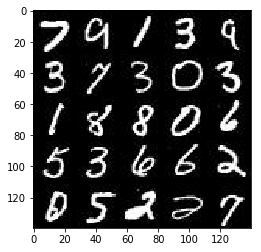

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

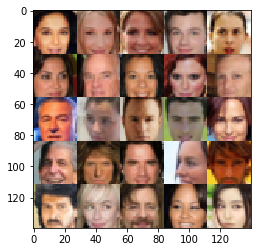

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.5891... Generator Loss: 13.0290
Epoch 1/2... Batch 20... Discriminator Loss: 0.6485... Generator Loss: 2.4841
Epoch 1/2... Batch 30... Discriminator Loss: 0.4350... Generator Loss: 5.3025
Epoch 1/2... Batch 40... Discriminator Loss: 0.6115... Generator Loss: 2.5707
Epoch 1/2... Batch 50... Discriminator Loss: 0.7384... Generator Loss: 2.3519
Epoch 1/2... Batch 60... Discriminator Loss: 1.5861... Generator Loss: 0.5450
Epoch 1/2... Batch 70... Discriminator Loss: 1.0043... Generator Loss: 1.5391
Epoch 1/2... Batch 80... Discriminator Loss: 1.1614... Generator Loss: 1.5992
Epoch 1/2... Batch 90... Discriminator Loss: 1.0163... Generator Loss: 1.6053
Epoch 1/2... Batch 100... Discriminator Loss: 1.1901... Generator Loss: 0.8900


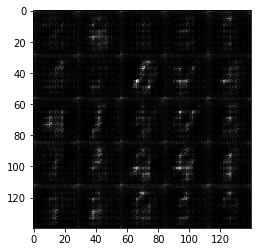

Epoch 1/2... Batch 110... Discriminator Loss: 1.0876... Generator Loss: 1.0099
Epoch 1/2... Batch 120... Discriminator Loss: 0.9202... Generator Loss: 1.6486
Epoch 1/2... Batch 130... Discriminator Loss: 1.1189... Generator Loss: 1.2641
Epoch 1/2... Batch 140... Discriminator Loss: 1.5876... Generator Loss: 2.5462
Epoch 1/2... Batch 150... Discriminator Loss: 1.4876... Generator Loss: 0.5363
Epoch 1/2... Batch 160... Discriminator Loss: 1.3620... Generator Loss: 0.7459
Epoch 1/2... Batch 170... Discriminator Loss: 1.5803... Generator Loss: 0.4378
Epoch 1/2... Batch 180... Discriminator Loss: 1.1861... Generator Loss: 1.0171
Epoch 1/2... Batch 190... Discriminator Loss: 1.1091... Generator Loss: 1.0067
Epoch 1/2... Batch 200... Discriminator Loss: 1.1926... Generator Loss: 1.0587


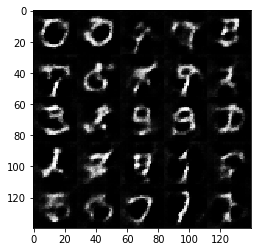

Epoch 1/2... Batch 210... Discriminator Loss: 1.1895... Generator Loss: 0.9139
Epoch 1/2... Batch 220... Discriminator Loss: 1.2562... Generator Loss: 1.1969
Epoch 1/2... Batch 230... Discriminator Loss: 1.4647... Generator Loss: 0.4708
Epoch 1/2... Batch 240... Discriminator Loss: 1.1848... Generator Loss: 0.9651
Epoch 1/2... Batch 250... Discriminator Loss: 1.4853... Generator Loss: 2.1494
Epoch 1/2... Batch 260... Discriminator Loss: 1.0853... Generator Loss: 1.0393
Epoch 1/2... Batch 270... Discriminator Loss: 1.1945... Generator Loss: 0.8648
Epoch 1/2... Batch 280... Discriminator Loss: 1.2789... Generator Loss: 0.6879
Epoch 1/2... Batch 290... Discriminator Loss: 1.1989... Generator Loss: 0.8086
Epoch 1/2... Batch 300... Discriminator Loss: 1.2278... Generator Loss: 1.3225


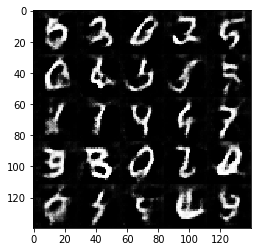

Epoch 1/2... Batch 310... Discriminator Loss: 1.1593... Generator Loss: 1.3618
Epoch 1/2... Batch 320... Discriminator Loss: 1.5255... Generator Loss: 0.4439
Epoch 1/2... Batch 330... Discriminator Loss: 1.2171... Generator Loss: 0.9255
Epoch 1/2... Batch 340... Discriminator Loss: 1.3743... Generator Loss: 1.7707
Epoch 1/2... Batch 350... Discriminator Loss: 1.1912... Generator Loss: 1.0507
Epoch 1/2... Batch 360... Discriminator Loss: 1.3604... Generator Loss: 1.8412
Epoch 1/2... Batch 370... Discriminator Loss: 1.1917... Generator Loss: 0.8966
Epoch 1/2... Batch 380... Discriminator Loss: 1.1982... Generator Loss: 1.2001
Epoch 1/2... Batch 390... Discriminator Loss: 1.1532... Generator Loss: 0.8212
Epoch 1/2... Batch 400... Discriminator Loss: 1.2436... Generator Loss: 0.6941


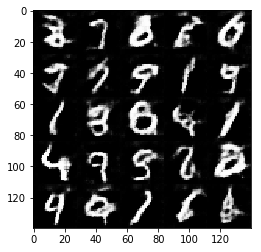

Epoch 1/2... Batch 410... Discriminator Loss: 1.3903... Generator Loss: 0.5443
Epoch 1/2... Batch 420... Discriminator Loss: 1.3175... Generator Loss: 0.5876
Epoch 1/2... Batch 430... Discriminator Loss: 1.2409... Generator Loss: 1.0519
Epoch 1/2... Batch 440... Discriminator Loss: 1.2222... Generator Loss: 0.9810
Epoch 1/2... Batch 450... Discriminator Loss: 1.1515... Generator Loss: 1.1714
Epoch 1/2... Batch 460... Discriminator Loss: 1.5582... Generator Loss: 0.4082
Epoch 2/2... Batch 10... Discriminator Loss: 1.1856... Generator Loss: 1.0178
Epoch 2/2... Batch 20... Discriminator Loss: 1.3965... Generator Loss: 1.7642
Epoch 2/2... Batch 30... Discriminator Loss: 1.1377... Generator Loss: 1.2677
Epoch 2/2... Batch 40... Discriminator Loss: 1.1760... Generator Loss: 1.2032
Epoch 2/2... Batch 50... Discriminator Loss: 1.7378... Generator Loss: 2.0105
Epoch 2/2... Batch 60... Discriminator Loss: 1.2057... Generator Loss: 1.1430
Epoch 2/2... Batch 70... Discriminator Loss: 1.0907... Gen

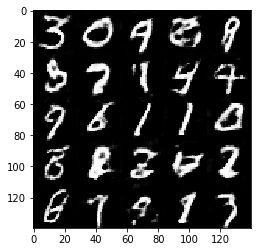

Epoch 2/2... Batch 110... Discriminator Loss: 1.2134... Generator Loss: 1.2625
Epoch 2/2... Batch 120... Discriminator Loss: 1.2047... Generator Loss: 1.3777
Epoch 2/2... Batch 130... Discriminator Loss: 1.1787... Generator Loss: 0.7507
Epoch 2/2... Batch 140... Discriminator Loss: 1.4965... Generator Loss: 1.3145
Epoch 2/2... Batch 150... Discriminator Loss: 1.2820... Generator Loss: 0.8599
Epoch 2/2... Batch 160... Discriminator Loss: 1.2871... Generator Loss: 1.1946
Epoch 2/2... Batch 170... Discriminator Loss: 1.2681... Generator Loss: 1.3223
Epoch 2/2... Batch 180... Discriminator Loss: 1.1413... Generator Loss: 1.1131
Epoch 2/2... Batch 190... Discriminator Loss: 1.3810... Generator Loss: 0.5256
Epoch 2/2... Batch 200... Discriminator Loss: 1.1043... Generator Loss: 1.1319


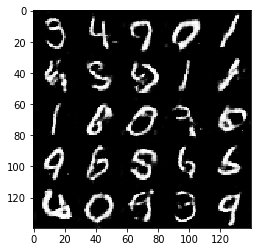

Epoch 2/2... Batch 210... Discriminator Loss: 1.1887... Generator Loss: 1.1085
Epoch 2/2... Batch 220... Discriminator Loss: 1.0593... Generator Loss: 1.3344
Epoch 2/2... Batch 230... Discriminator Loss: 1.1928... Generator Loss: 1.1095
Epoch 2/2... Batch 240... Discriminator Loss: 1.9342... Generator Loss: 0.2666
Epoch 2/2... Batch 250... Discriminator Loss: 1.2344... Generator Loss: 0.6982
Epoch 2/2... Batch 260... Discriminator Loss: 1.6030... Generator Loss: 0.4136
Epoch 2/2... Batch 270... Discriminator Loss: 1.1930... Generator Loss: 1.3546
Epoch 2/2... Batch 300... Discriminator Loss: 1.2397... Generator Loss: 0.8177


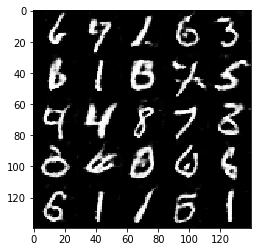

Epoch 2/2... Batch 310... Discriminator Loss: 1.2719... Generator Loss: 1.1533
Epoch 2/2... Batch 320... Discriminator Loss: 1.2566... Generator Loss: 0.7336
Epoch 2/2... Batch 330... Discriminator Loss: 1.1483... Generator Loss: 0.9770
Epoch 2/2... Batch 340... Discriminator Loss: 1.0355... Generator Loss: 1.4510
Epoch 2/2... Batch 350... Discriminator Loss: 1.3567... Generator Loss: 0.5424
Epoch 2/2... Batch 360... Discriminator Loss: 1.8341... Generator Loss: 0.3590
Epoch 2/2... Batch 370... Discriminator Loss: 1.2037... Generator Loss: 0.8241
Epoch 2/2... Batch 380... Discriminator Loss: 1.2113... Generator Loss: 1.0851
Epoch 2/2... Batch 390... Discriminator Loss: 1.1643... Generator Loss: 0.8287
Epoch 2/2... Batch 400... Discriminator Loss: 1.2090... Generator Loss: 0.7786


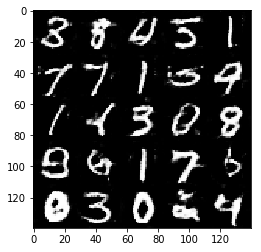

Epoch 2/2... Batch 410... Discriminator Loss: 1.1288... Generator Loss: 0.9659
Epoch 2/2... Batch 420... Discriminator Loss: 1.4822... Generator Loss: 0.4737
Epoch 2/2... Batch 430... Discriminator Loss: 1.0700... Generator Loss: 1.5732
Epoch 2/2... Batch 440... Discriminator Loss: 1.6730... Generator Loss: 0.3666
Epoch 2/2... Batch 450... Discriminator Loss: 1.3492... Generator Loss: 0.5593
Epoch 2/2... Batch 460... Discriminator Loss: 1.0839... Generator Loss: 0.9905


In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 1.5106... Generator Loss: 0.5438
Epoch 1/1... Batch 20... Discriminator Loss: 0.9451... Generator Loss: 1.0906
Epoch 1/1... Batch 30... Discriminator Loss: 0.6982... Generator Loss: 1.5173
Epoch 1/1... Batch 40... Discriminator Loss: 0.6026... Generator Loss: 2.6635
Epoch 1/1... Batch 50... Discriminator Loss: 0.6042... Generator Loss: 2.0164
Epoch 1/1... Batch 60... Discriminator Loss: 0.5889... Generator Loss: 1.7264
Epoch 1/1... Batch 70... Discriminator Loss: 0.5411... Generator Loss: 2.5409
Epoch 1/1... Batch 80... Discriminator Loss: 0.4646... Generator Loss: 2.9080
Epoch 1/1... Batch 90... Discriminator Loss: 0.5102... Generator Loss: 2.5099
Epoch 1/1... Batch 100... Discriminator Loss: 0.5219... Generator Loss: 2.2751


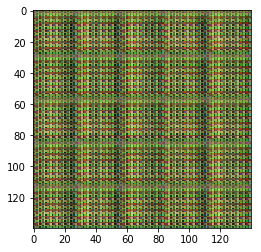

Epoch 1/1... Batch 110... Discriminator Loss: 1.0405... Generator Loss: 0.7944
Epoch 1/1... Batch 120... Discriminator Loss: 0.4965... Generator Loss: 2.5575
Epoch 1/1... Batch 130... Discriminator Loss: 0.7261... Generator Loss: 2.8944
Epoch 1/1... Batch 140... Discriminator Loss: 0.6951... Generator Loss: 1.9513
Epoch 1/1... Batch 150... Discriminator Loss: 0.9739... Generator Loss: 3.1480
Epoch 1/1... Batch 160... Discriminator Loss: 0.8383... Generator Loss: 1.4636
Epoch 1/1... Batch 170... Discriminator Loss: 0.8641... Generator Loss: 1.5915
Epoch 1/1... Batch 180... Discriminator Loss: 0.7282... Generator Loss: 1.5869
Epoch 1/1... Batch 190... Discriminator Loss: 0.9600... Generator Loss: 1.0104
Epoch 1/1... Batch 200... Discriminator Loss: 0.9392... Generator Loss: 1.0099


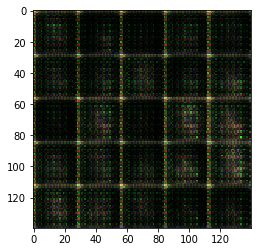

Epoch 1/1... Batch 210... Discriminator Loss: 0.7305... Generator Loss: 1.7985
Epoch 1/1... Batch 220... Discriminator Loss: 0.9532... Generator Loss: 2.5910
Epoch 1/1... Batch 230... Discriminator Loss: 0.6761... Generator Loss: 1.6156
Epoch 1/1... Batch 240... Discriminator Loss: 0.9349... Generator Loss: 1.4913
Epoch 1/1... Batch 250... Discriminator Loss: 0.7282... Generator Loss: 1.8071
Epoch 1/1... Batch 260... Discriminator Loss: 0.7902... Generator Loss: 1.4711
Epoch 1/1... Batch 270... Discriminator Loss: 0.9541... Generator Loss: 2.0841
Epoch 1/1... Batch 280... Discriminator Loss: 0.8463... Generator Loss: 1.7638
Epoch 1/1... Batch 290... Discriminator Loss: 0.9446... Generator Loss: 1.0255
Epoch 1/1... Batch 300... Discriminator Loss: 1.0531... Generator Loss: 0.9835


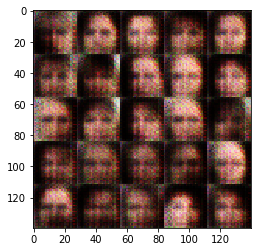

Epoch 1/1... Batch 310... Discriminator Loss: 0.8250... Generator Loss: 1.6512
Epoch 1/1... Batch 320... Discriminator Loss: 1.0791... Generator Loss: 1.3344
Epoch 1/1... Batch 330... Discriminator Loss: 0.8450... Generator Loss: 1.4634
Epoch 1/1... Batch 340... Discriminator Loss: 0.9716... Generator Loss: 1.1216
Epoch 1/1... Batch 350... Discriminator Loss: 1.0339... Generator Loss: 1.7815
Epoch 1/1... Batch 360... Discriminator Loss: 0.9732... Generator Loss: 1.2238
Epoch 1/1... Batch 370... Discriminator Loss: 0.8659... Generator Loss: 1.1802
Epoch 1/1... Batch 380... Discriminator Loss: 0.7487... Generator Loss: 1.6057
Epoch 1/1... Batch 390... Discriminator Loss: 1.0775... Generator Loss: 2.5796
Epoch 1/1... Batch 400... Discriminator Loss: 0.9185... Generator Loss: 1.2034


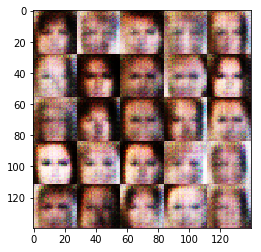

Epoch 1/1... Batch 410... Discriminator Loss: 0.9307... Generator Loss: 1.1020
Epoch 1/1... Batch 420... Discriminator Loss: 1.0691... Generator Loss: 0.8685
Epoch 1/1... Batch 430... Discriminator Loss: 1.0994... Generator Loss: 0.8061
Epoch 1/1... Batch 440... Discriminator Loss: 1.0894... Generator Loss: 1.4497
Epoch 1/1... Batch 450... Discriminator Loss: 0.8286... Generator Loss: 2.4240
Epoch 1/1... Batch 460... Discriminator Loss: 0.7862... Generator Loss: 1.7685
Epoch 1/1... Batch 470... Discriminator Loss: 0.8007... Generator Loss: 1.4830
Epoch 1/1... Batch 480... Discriminator Loss: 0.9645... Generator Loss: 1.3643
Epoch 1/1... Batch 490... Discriminator Loss: 0.7933... Generator Loss: 1.5945
Epoch 1/1... Batch 500... Discriminator Loss: 0.8635... Generator Loss: 2.0238


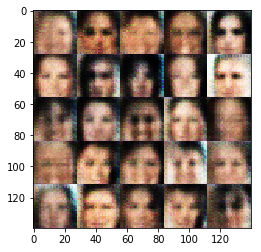

Epoch 1/1... Batch 510... Discriminator Loss: 1.2662... Generator Loss: 0.5940
Epoch 1/1... Batch 520... Discriminator Loss: 1.0828... Generator Loss: 0.8971
Epoch 1/1... Batch 530... Discriminator Loss: 1.1315... Generator Loss: 1.8734
Epoch 1/1... Batch 540... Discriminator Loss: 1.2954... Generator Loss: 0.6595
Epoch 1/1... Batch 550... Discriminator Loss: 1.3772... Generator Loss: 0.5835
Epoch 1/1... Batch 560... Discriminator Loss: 1.0430... Generator Loss: 1.3767
Epoch 1/1... Batch 570... Discriminator Loss: 1.1262... Generator Loss: 1.9164
Epoch 1/1... Batch 580... Discriminator Loss: 1.1113... Generator Loss: 0.8506
Epoch 1/1... Batch 590... Discriminator Loss: 0.9482... Generator Loss: 1.4531
Epoch 1/1... Batch 600... Discriminator Loss: 1.0610... Generator Loss: 1.5888


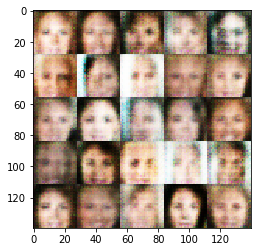

Epoch 1/1... Batch 610... Discriminator Loss: 1.0788... Generator Loss: 1.7593
Epoch 1/1... Batch 620... Discriminator Loss: 1.0729... Generator Loss: 1.0274
Epoch 1/1... Batch 630... Discriminator Loss: 1.1708... Generator Loss: 0.7946
Epoch 1/1... Batch 640... Discriminator Loss: 1.1872... Generator Loss: 0.8138
Epoch 1/1... Batch 650... Discriminator Loss: 1.2692... Generator Loss: 0.6578
Epoch 1/1... Batch 660... Discriminator Loss: 1.0937... Generator Loss: 1.5588
Epoch 1/1... Batch 670... Discriminator Loss: 1.1458... Generator Loss: 0.8581
Epoch 1/1... Batch 680... Discriminator Loss: 1.0144... Generator Loss: 1.0294
Epoch 1/1... Batch 690... Discriminator Loss: 1.2882... Generator Loss: 0.6635
Epoch 1/1... Batch 700... Discriminator Loss: 1.2414... Generator Loss: 0.6446


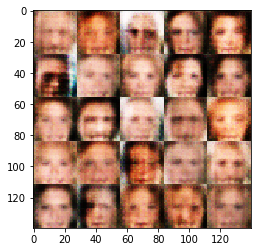

Epoch 1/1... Batch 710... Discriminator Loss: 1.0518... Generator Loss: 1.2629
Epoch 1/1... Batch 720... Discriminator Loss: 0.9336... Generator Loss: 1.2373
Epoch 1/1... Batch 730... Discriminator Loss: 1.0726... Generator Loss: 0.8548
Epoch 1/1... Batch 740... Discriminator Loss: 1.0678... Generator Loss: 1.0094
Epoch 1/1... Batch 750... Discriminator Loss: 1.1153... Generator Loss: 0.8225
Epoch 1/1... Batch 760... Discriminator Loss: 1.0809... Generator Loss: 1.0629
Epoch 1/1... Batch 770... Discriminator Loss: 0.9070... Generator Loss: 1.2722
Epoch 1/1... Batch 780... Discriminator Loss: 0.9117... Generator Loss: 1.4191
Epoch 1/1... Batch 790... Discriminator Loss: 0.9961... Generator Loss: 0.9015
Epoch 1/1... Batch 800... Discriminator Loss: 1.1067... Generator Loss: 0.7841


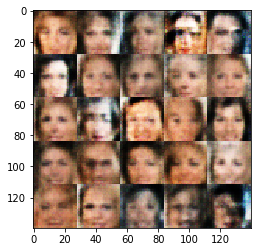

Epoch 1/1... Batch 810... Discriminator Loss: 1.1519... Generator Loss: 0.8585
Epoch 1/1... Batch 820... Discriminator Loss: 1.1866... Generator Loss: 0.9859
Epoch 1/1... Batch 830... Discriminator Loss: 1.0874... Generator Loss: 1.3850
Epoch 1/1... Batch 840... Discriminator Loss: 1.0880... Generator Loss: 0.8924
Epoch 1/1... Batch 850... Discriminator Loss: 0.9929... Generator Loss: 1.5872
Epoch 1/1... Batch 860... Discriminator Loss: 0.9944... Generator Loss: 1.5900
Epoch 1/1... Batch 870... Discriminator Loss: 1.2711... Generator Loss: 0.7360
Epoch 1/1... Batch 880... Discriminator Loss: 1.1998... Generator Loss: 0.8473
Epoch 1/1... Batch 890... Discriminator Loss: 0.9948... Generator Loss: 1.1662
Epoch 1/1... Batch 900... Discriminator Loss: 1.0088... Generator Loss: 1.8301


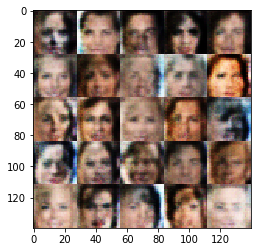

Epoch 1/1... Batch 910... Discriminator Loss: 1.3010... Generator Loss: 0.8674
Epoch 1/1... Batch 920... Discriminator Loss: 1.1655... Generator Loss: 0.8164
Epoch 1/1... Batch 930... Discriminator Loss: 1.1012... Generator Loss: 0.9058
Epoch 1/1... Batch 940... Discriminator Loss: 1.3006... Generator Loss: 0.6073
Epoch 1/1... Batch 950... Discriminator Loss: 1.0876... Generator Loss: 0.8195
Epoch 1/1... Batch 960... Discriminator Loss: 1.0883... Generator Loss: 1.4600
Epoch 1/1... Batch 970... Discriminator Loss: 1.0758... Generator Loss: 0.8938
Epoch 1/1... Batch 980... Discriminator Loss: 1.0147... Generator Loss: 1.1779
Epoch 1/1... Batch 990... Discriminator Loss: 1.2317... Generator Loss: 0.6904
Epoch 1/1... Batch 1000... Discriminator Loss: 1.0056... Generator Loss: 1.1946


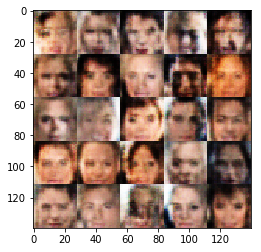

Epoch 1/1... Batch 1010... Discriminator Loss: 1.0799... Generator Loss: 0.8415
Epoch 1/1... Batch 1020... Discriminator Loss: 1.1501... Generator Loss: 0.7548
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2219... Generator Loss: 0.7749
Epoch 1/1... Batch 1040... Discriminator Loss: 1.1358... Generator Loss: 0.7991
Epoch 1/1... Batch 1050... Discriminator Loss: 1.1004... Generator Loss: 1.0148
Epoch 1/1... Batch 1060... Discriminator Loss: 1.0638... Generator Loss: 1.1843
Epoch 1/1... Batch 1070... Discriminator Loss: 0.9579... Generator Loss: 1.2949
Epoch 1/1... Batch 1080... Discriminator Loss: 1.1112... Generator Loss: 0.9404
Epoch 1/1... Batch 1090... Discriminator Loss: 1.1815... Generator Loss: 0.8095
Epoch 1/1... Batch 1100... Discriminator Loss: 1.1021... Generator Loss: 0.9148


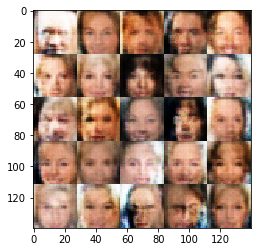

Epoch 1/1... Batch 1110... Discriminator Loss: 1.1510... Generator Loss: 0.7315
Epoch 1/1... Batch 1120... Discriminator Loss: 1.0254... Generator Loss: 1.0120
Epoch 1/1... Batch 1130... Discriminator Loss: 1.0420... Generator Loss: 0.9584
Epoch 1/1... Batch 1140... Discriminator Loss: 0.8877... Generator Loss: 1.2422
Epoch 1/1... Batch 1150... Discriminator Loss: 0.9895... Generator Loss: 1.1834
Epoch 1/1... Batch 1160... Discriminator Loss: 1.0403... Generator Loss: 1.5469
Epoch 1/1... Batch 1170... Discriminator Loss: 1.1761... Generator Loss: 0.7531
Epoch 1/1... Batch 1180... Discriminator Loss: 1.2367... Generator Loss: 0.7307
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1430... Generator Loss: 1.5441
Epoch 1/1... Batch 1200... Discriminator Loss: 0.8841... Generator Loss: 1.3929


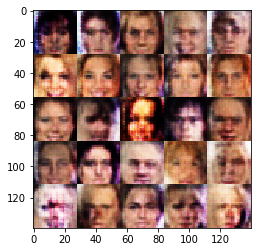

Epoch 1/1... Batch 1210... Discriminator Loss: 1.1537... Generator Loss: 0.7984
Epoch 1/1... Batch 1220... Discriminator Loss: 0.9729... Generator Loss: 1.3335
Epoch 1/1... Batch 1230... Discriminator Loss: 1.0665... Generator Loss: 0.9246
Epoch 1/1... Batch 1240... Discriminator Loss: 1.1420... Generator Loss: 0.8147
Epoch 1/1... Batch 1250... Discriminator Loss: 1.0280... Generator Loss: 1.2370
Epoch 1/1... Batch 1260... Discriminator Loss: 1.0569... Generator Loss: 1.2448
Epoch 1/1... Batch 1270... Discriminator Loss: 0.9191... Generator Loss: 1.5503
Epoch 1/1... Batch 1280... Discriminator Loss: 1.1509... Generator Loss: 1.0425
Epoch 1/1... Batch 1290... Discriminator Loss: 1.1537... Generator Loss: 2.1271
Epoch 1/1... Batch 1300... Discriminator Loss: 1.1083... Generator Loss: 0.9405


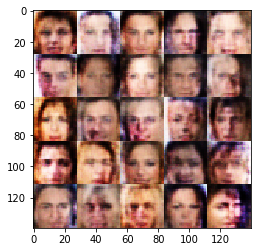

Epoch 1/1... Batch 1310... Discriminator Loss: 0.8345... Generator Loss: 1.3949
Epoch 1/1... Batch 1320... Discriminator Loss: 1.0318... Generator Loss: 0.8386
Epoch 1/1... Batch 1330... Discriminator Loss: 1.1288... Generator Loss: 1.2289
Epoch 1/1... Batch 1340... Discriminator Loss: 0.9436... Generator Loss: 1.1203
Epoch 1/1... Batch 1350... Discriminator Loss: 1.0466... Generator Loss: 0.9773
Epoch 1/1... Batch 1360... Discriminator Loss: 0.8703... Generator Loss: 1.2234
Epoch 1/1... Batch 1370... Discriminator Loss: 1.2834... Generator Loss: 0.5934
Epoch 1/1... Batch 1380... Discriminator Loss: 0.9473... Generator Loss: 1.3648
Epoch 1/1... Batch 1390... Discriminator Loss: 1.1044... Generator Loss: 1.4590
Epoch 1/1... Batch 1400... Discriminator Loss: 1.0031... Generator Loss: 1.0510


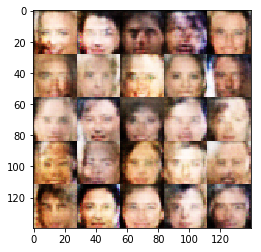

Epoch 1/1... Batch 1410... Discriminator Loss: 1.1913... Generator Loss: 0.7132
Epoch 1/1... Batch 1420... Discriminator Loss: 1.1417... Generator Loss: 1.0934
Epoch 1/1... Batch 1430... Discriminator Loss: 1.2120... Generator Loss: 1.3735
Epoch 1/1... Batch 1440... Discriminator Loss: 0.9023... Generator Loss: 1.1165
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2136... Generator Loss: 0.6858
Epoch 1/1... Batch 1460... Discriminator Loss: 1.1330... Generator Loss: 1.2756
Epoch 1/1... Batch 1470... Discriminator Loss: 1.4061... Generator Loss: 0.5004
Epoch 1/1... Batch 1480... Discriminator Loss: 0.7804... Generator Loss: 1.7750
Epoch 1/1... Batch 1490... Discriminator Loss: 0.8344... Generator Loss: 1.5464
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2106... Generator Loss: 0.7077


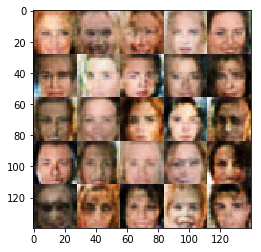

Epoch 1/1... Batch 1510... Discriminator Loss: 0.9259... Generator Loss: 1.1393
Epoch 1/1... Batch 1520... Discriminator Loss: 1.3093... Generator Loss: 0.5800
Epoch 1/1... Batch 1530... Discriminator Loss: 1.0882... Generator Loss: 1.3235
Epoch 1/1... Batch 1540... Discriminator Loss: 0.8502... Generator Loss: 1.2074
Epoch 1/1... Batch 1550... Discriminator Loss: 1.3509... Generator Loss: 0.5546
Epoch 1/1... Batch 1560... Discriminator Loss: 1.5977... Generator Loss: 0.4098
Epoch 1/1... Batch 1570... Discriminator Loss: 0.9523... Generator Loss: 1.4404
Epoch 1/1... Batch 1580... Discriminator Loss: 1.1023... Generator Loss: 1.0851
Epoch 1/1... Batch 1590... Discriminator Loss: 0.9981... Generator Loss: 1.0050
Epoch 1/1... Batch 1600... Discriminator Loss: 1.0976... Generator Loss: 0.8115


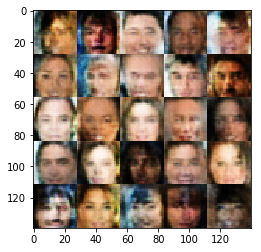

Epoch 1/1... Batch 1610... Discriminator Loss: 1.1769... Generator Loss: 0.7371
Epoch 1/1... Batch 1620... Discriminator Loss: 1.1273... Generator Loss: 0.7566
Epoch 1/1... Batch 1630... Discriminator Loss: 1.0892... Generator Loss: 0.8722
Epoch 1/1... Batch 1640... Discriminator Loss: 0.8731... Generator Loss: 1.2715
Epoch 1/1... Batch 1650... Discriminator Loss: 1.2302... Generator Loss: 1.3927
Epoch 1/1... Batch 1660... Discriminator Loss: 1.2765... Generator Loss: 0.6522
Epoch 1/1... Batch 1670... Discriminator Loss: 1.2761... Generator Loss: 1.9417
Epoch 1/1... Batch 1680... Discriminator Loss: 1.0533... Generator Loss: 0.9841
Epoch 1/1... Batch 1690... Discriminator Loss: 1.1500... Generator Loss: 0.9888
Epoch 1/1... Batch 1700... Discriminator Loss: 0.9662... Generator Loss: 1.1712


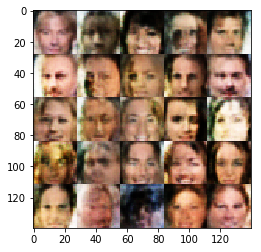

Epoch 1/1... Batch 1710... Discriminator Loss: 1.1658... Generator Loss: 0.7398
Epoch 1/1... Batch 1720... Discriminator Loss: 1.0557... Generator Loss: 0.9690
Epoch 1/1... Batch 1730... Discriminator Loss: 1.0256... Generator Loss: 1.2540
Epoch 1/1... Batch 1740... Discriminator Loss: 0.8408... Generator Loss: 1.5765
Epoch 1/1... Batch 1750... Discriminator Loss: 0.9823... Generator Loss: 1.2111
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1006... Generator Loss: 0.8997
Epoch 1/1... Batch 1770... Discriminator Loss: 1.0741... Generator Loss: 1.1157
Epoch 1/1... Batch 1780... Discriminator Loss: 1.1695... Generator Loss: 0.6823
Epoch 1/1... Batch 1790... Discriminator Loss: 1.3777... Generator Loss: 0.5482
Epoch 1/1... Batch 1800... Discriminator Loss: 0.9181... Generator Loss: 1.3504


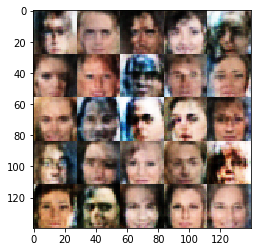

Epoch 1/1... Batch 1810... Discriminator Loss: 1.0509... Generator Loss: 0.8633
Epoch 1/1... Batch 1820... Discriminator Loss: 1.0277... Generator Loss: 1.4393
Epoch 1/1... Batch 1830... Discriminator Loss: 1.0668... Generator Loss: 1.0813
Epoch 1/1... Batch 1840... Discriminator Loss: 0.8052... Generator Loss: 1.2987
Epoch 1/1... Batch 1850... Discriminator Loss: 1.0357... Generator Loss: 0.8753
Epoch 1/1... Batch 1860... Discriminator Loss: 0.9563... Generator Loss: 1.2872
Epoch 1/1... Batch 1870... Discriminator Loss: 1.1993... Generator Loss: 0.7216
Epoch 1/1... Batch 1880... Discriminator Loss: 1.5590... Generator Loss: 0.4229
Epoch 1/1... Batch 1890... Discriminator Loss: 1.0112... Generator Loss: 1.1843
Epoch 1/1... Batch 1900... Discriminator Loss: 0.9725... Generator Loss: 1.2435


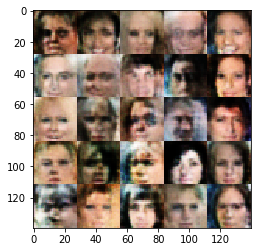

Epoch 1/1... Batch 1910... Discriminator Loss: 1.3895... Generator Loss: 0.5869
Epoch 1/1... Batch 1920... Discriminator Loss: 0.9938... Generator Loss: 1.1122
Epoch 1/1... Batch 1930... Discriminator Loss: 1.1621... Generator Loss: 0.8211
Epoch 1/1... Batch 1940... Discriminator Loss: 1.1997... Generator Loss: 0.9491
Epoch 1/1... Batch 1950... Discriminator Loss: 0.8625... Generator Loss: 1.2528
Epoch 1/1... Batch 1960... Discriminator Loss: 0.9167... Generator Loss: 1.2103
Epoch 1/1... Batch 1970... Discriminator Loss: 1.1301... Generator Loss: 0.9731
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1238... Generator Loss: 0.9002
Epoch 1/1... Batch 1990... Discriminator Loss: 1.3589... Generator Loss: 0.5604
Epoch 1/1... Batch 2000... Discriminator Loss: 1.1652... Generator Loss: 1.0558


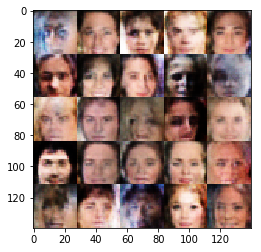

Epoch 1/1... Batch 2010... Discriminator Loss: 1.0685... Generator Loss: 0.9038
Epoch 1/1... Batch 2020... Discriminator Loss: 1.1157... Generator Loss: 0.8072
Epoch 1/1... Batch 2030... Discriminator Loss: 0.9312... Generator Loss: 1.2939
Epoch 1/1... Batch 2040... Discriminator Loss: 1.1335... Generator Loss: 0.9383
Epoch 1/1... Batch 2050... Discriminator Loss: 1.1322... Generator Loss: 0.9159
Epoch 1/1... Batch 2060... Discriminator Loss: 0.9148... Generator Loss: 1.4699
Epoch 1/1... Batch 2070... Discriminator Loss: 0.9088... Generator Loss: 1.2466
Epoch 1/1... Batch 2080... Discriminator Loss: 1.1327... Generator Loss: 0.9387
Epoch 1/1... Batch 2090... Discriminator Loss: 1.0972... Generator Loss: 1.0007
Epoch 1/1... Batch 2100... Discriminator Loss: 1.5751... Generator Loss: 0.4163


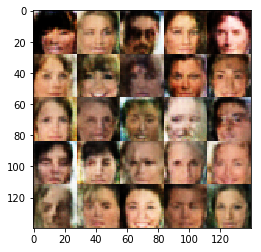

Epoch 1/1... Batch 2110... Discriminator Loss: 1.0563... Generator Loss: 1.4767
Epoch 1/1... Batch 2120... Discriminator Loss: 1.0626... Generator Loss: 1.2217
Epoch 1/1... Batch 2130... Discriminator Loss: 1.0818... Generator Loss: 1.1547
Epoch 1/1... Batch 2140... Discriminator Loss: 1.1212... Generator Loss: 0.7961
Epoch 1/1... Batch 2150... Discriminator Loss: 1.0530... Generator Loss: 1.0084
Epoch 1/1... Batch 2160... Discriminator Loss: 1.0374... Generator Loss: 0.8175
Epoch 1/1... Batch 2170... Discriminator Loss: 1.2965... Generator Loss: 0.5758
Epoch 1/1... Batch 2180... Discriminator Loss: 1.2377... Generator Loss: 0.7255
Epoch 1/1... Batch 2190... Discriminator Loss: 1.0866... Generator Loss: 1.0412
Epoch 1/1... Batch 2200... Discriminator Loss: 1.2571... Generator Loss: 1.4577


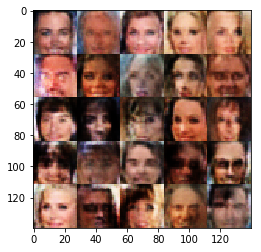

Epoch 1/1... Batch 2210... Discriminator Loss: 1.6121... Generator Loss: 0.3897
Epoch 1/1... Batch 2220... Discriminator Loss: 1.0602... Generator Loss: 1.2333
Epoch 1/1... Batch 2230... Discriminator Loss: 1.4103... Generator Loss: 0.8820
Epoch 1/1... Batch 2240... Discriminator Loss: 0.9231... Generator Loss: 1.3091
Epoch 1/1... Batch 2250... Discriminator Loss: 1.1531... Generator Loss: 0.7937
Epoch 1/1... Batch 2260... Discriminator Loss: 1.2550... Generator Loss: 0.6317
Epoch 1/1... Batch 2270... Discriminator Loss: 1.2612... Generator Loss: 0.6288
Epoch 1/1... Batch 2280... Discriminator Loss: 0.8862... Generator Loss: 1.1035
Epoch 1/1... Batch 2290... Discriminator Loss: 1.1931... Generator Loss: 1.0915
Epoch 1/1... Batch 2300... Discriminator Loss: 0.9837... Generator Loss: 1.0938


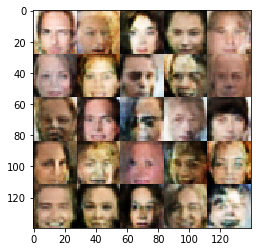

Epoch 1/1... Batch 2310... Discriminator Loss: 1.0962... Generator Loss: 0.9543
Epoch 1/1... Batch 2320... Discriminator Loss: 1.0246... Generator Loss: 0.9679
Epoch 1/1... Batch 2330... Discriminator Loss: 1.0063... Generator Loss: 0.9368
Epoch 1/1... Batch 2340... Discriminator Loss: 1.3045... Generator Loss: 0.6209
Epoch 1/1... Batch 2350... Discriminator Loss: 1.0746... Generator Loss: 1.0852
Epoch 1/1... Batch 2360... Discriminator Loss: 1.2314... Generator Loss: 0.8518
Epoch 1/1... Batch 2370... Discriminator Loss: 0.9418... Generator Loss: 0.9816
Epoch 1/1... Batch 2380... Discriminator Loss: 1.0994... Generator Loss: 1.1019
Epoch 1/1... Batch 2390... Discriminator Loss: 0.8059... Generator Loss: 1.2470
Epoch 1/1... Batch 2400... Discriminator Loss: 1.1205... Generator Loss: 0.8675


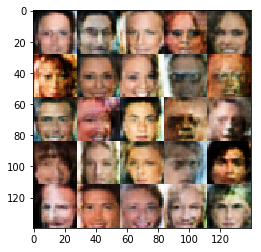

Epoch 1/1... Batch 2410... Discriminator Loss: 1.0894... Generator Loss: 1.3258
Epoch 1/1... Batch 2420... Discriminator Loss: 1.1238... Generator Loss: 0.9684
Epoch 1/1... Batch 2430... Discriminator Loss: 1.1778... Generator Loss: 0.9260
Epoch 1/1... Batch 2440... Discriminator Loss: 1.1233... Generator Loss: 0.7957
Epoch 1/1... Batch 2450... Discriminator Loss: 0.9530... Generator Loss: 1.1798
Epoch 1/1... Batch 2460... Discriminator Loss: 0.8757... Generator Loss: 1.2752
Epoch 1/1... Batch 2470... Discriminator Loss: 1.3416... Generator Loss: 0.7915
Epoch 1/1... Batch 2480... Discriminator Loss: 1.1619... Generator Loss: 0.8239
Epoch 1/1... Batch 2490... Discriminator Loss: 1.0697... Generator Loss: 0.7934
Epoch 1/1... Batch 2500... Discriminator Loss: 1.2225... Generator Loss: 0.8383


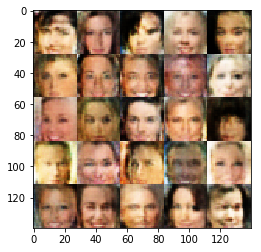

Epoch 1/1... Batch 2510... Discriminator Loss: 1.1335... Generator Loss: 1.5928
Epoch 1/1... Batch 2520... Discriminator Loss: 1.1260... Generator Loss: 0.8839
Epoch 1/1... Batch 2530... Discriminator Loss: 1.1876... Generator Loss: 0.7953
Epoch 1/1... Batch 2540... Discriminator Loss: 1.1678... Generator Loss: 0.7991
Epoch 1/1... Batch 2550... Discriminator Loss: 1.3163... Generator Loss: 0.6789
Epoch 1/1... Batch 2560... Discriminator Loss: 1.2361... Generator Loss: 0.6091
Epoch 1/1... Batch 2570... Discriminator Loss: 1.2825... Generator Loss: 0.6044
Epoch 1/1... Batch 2580... Discriminator Loss: 1.1932... Generator Loss: 0.9724
Epoch 1/1... Batch 2590... Discriminator Loss: 1.1378... Generator Loss: 0.8000
Epoch 1/1... Batch 2600... Discriminator Loss: 1.0838... Generator Loss: 0.8720


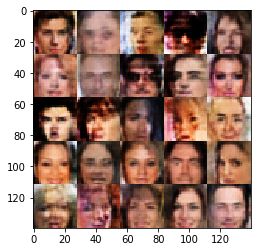

Epoch 1/1... Batch 2610... Discriminator Loss: 0.8064... Generator Loss: 1.2604


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.